In [9]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC


from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score, f1_score

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel

from sklearn.pipeline import Pipeline

from collections import Counter
import matplotlib.pyplot as plt

import joblib

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import preprocessing_utils as preproc
import config

In [10]:
# Loading in the mRNA and clinical data:
clinical_df = pd.read_csv("../ucec_tcga_pan_can_atlas_2018\data_clinical_patient.txt", sep="\t", comment="#", low_memory=False)
clinical_df = clinical_df.set_index('PATIENT_ID')

mrna_df = pd.read_csv("../ucec_tcga_pan_can_atlas_2018/data_mrna_seq_v2_rsem_zscores_ref_all_samples.txt", sep="\t", comment="#")

# There are 527 patients in the mRNA and 529 patients in the clinical data

# The first 2 columns of the mRNA data are labels (Hugo_Symbol then Entrez_Gene_Id). 
# 13 of the genes do not have Hugo_symbols, so for these I will you the Entrex_Gene_Id as the label.
missing_symbols = mrna_df['Hugo_Symbol'].isnull()
mrna_df.loc[missing_symbols, 'Hugo_Symbol'] = mrna_df.loc[missing_symbols, 'Entrez_Gene_Id'].astype(str)

# There are 7 rows that have both the same Hugo_Symbol and Entrez_Gene_Id but different values for the patients.
# I will rename these rows to have unique labels by appending -1-of-2 and -2-of-2 to the Hugo_Symbol.
# Get value counts
counts = mrna_df['Hugo_Symbol'].value_counts()

# Generate unique labels for duplicates
def label_duplicates(value, index):
    if counts[value] == 1:
        return value  # Keep unique values unchanged
    occurrence = mrna_df.groupby('Hugo_Symbol').cumcount() + 1  # Count occurrences per group
    return f"{value}-{occurrence[index]}-of-{counts[value]}"

# Apply the labeling function
mrna_df['Hugo_Symbol'] = [label_duplicates(value, idx) for idx, value in mrna_df['Hugo_Symbol'].items()]

mrna_df = mrna_df.set_index('Hugo_Symbol')
mrna_df = mrna_df.drop(columns="Entrez_Gene_Id") # removing the label column before I transpose the df
mrna_df= mrna_df.transpose() # now the patients are the index and the genes are the columns
mrna_df.index = [id[:-3] for id in mrna_df.index] # removes extranious -01 so that the patient ids match the clinical data


In [11]:
labels = preproc.assign_labels(clinical_df)
clinical_df, mrna_df, labels = preproc.drop_patients_missing_data(clinical_df, mrna_df, labels)

clinical_cols = clinical_df.columns.tolist()
mrna_cols = mrna_df.columns.tolist()
full_df = clinical_df.join(mrna_df, how="inner")

X_train, X_test, y_train, y_test = train_test_split(full_df, labels, test_size=0.2, random_state=1, stratify=labels)

preprocessor = ColumnTransformer(
    transformers=[
        ("clinical", preproc.ClinicalPreprocessorWrapper(
            cols_to_remove=config.CLINICAL_COLS_TO_REMOVE,
            categorical_cols=config.CATEGORICAL_COLS,
            max_null_frac=config.CLINICAL_MAX_NULL_FRAC,
            uniform_thresh=config.CLINICAL_UNIFORM_THRESH
        ), clinical_cols),

        ("mrna", preproc.MrnaPreprocessorWrapper(
            max_null_frac=config.MAX_NULL_FRAC,
            uniform_thresh=config.UNIFORM_THRESHOLD,
            corr_thresh=config.CORRELATION_THRESHOLD,
            var_thresh=config.VARIANCE_THRESHOLD,
            re_run_pruning=config.RE_RUN_PRUNING,
            literature_genes=config.LITERATURE_GENES,
            use_stability_selection=config.USE_STABILITY_SELECTION,
            n_boots=config.N_BOOTS,
            fpr_alpha=config.FPR_ALPHA,
            stability_threshold=config.STABILITY_THRESHOLD,
            random_state=config.SEED
        ), mrna_cols),
    ]
)


In [12]:
# --- Step 1: Assign labels and drop patients with missing data ---
labels = preproc.assign_labels(clinical_df)
clinical_df, mrna_df, labels = preproc.drop_patients_missing_data(clinical_df, mrna_df, labels)

# --- Step 2: Keep column lists ---
clinical_cols = clinical_df.columns.tolist()
mrna_cols = mrna_df.columns.tolist()

# --- Step 3: Merge dataframes ---
full_df = clinical_df.join(mrna_df, how="inner")

# --- Step 4: Split into train/test ---
X_train, X_test, y_train, y_test = train_test_split(
    full_df, labels, test_size=0.2, random_state=1, stratify=labels
)

# # --- Step 5: Define the ColumnTransformer (preprocessors) ---
# preprocessor = ColumnTransformer(
#     transformers=[
#         ("clinical", preproc.ClinicalPreprocessorWrapper(
#             cols_to_remove=config.CLINICAL_COLS_TO_REMOVE,
#             categorical_cols=config.CATEGORICAL_COLS,
#             max_null_frac=config.CLINICAL_MAX_NULL_FRAC,
#             uniform_thresh=config.CLINICAL_UNIFORM_THRESH
#         ), clinical_cols),

#         ("mrna", preproc.MrnaPreprocessorWrapper(
#             max_null_frac=config.MAX_NULL_FRAC,
#             uniform_thresh=config.UNIFORM_THRESHOLD,
#             corr_thresh=config.CORRELATION_THRESHOLD,
#             var_thresh=config.VARIANCE_THRESHOLD,
#             re_run_pruning=config.RE_RUN_PRUNING,
#             literature_genes=config.LITERATURE_GENES,
#             use_stability_selection=config.USE_STABILITY_SELECTION,
#             n_boots=config.N_BOOTS,
#             fpr_alpha=config.FPR_ALPHA,
#             stability_threshold=config.STABILITY_THRESHOLD,
#             random_state=config.SEED
#         ), mrna_cols),
#     ]
# )

# --- Step 6: Fit the preprocessor on training data ---
preprocessor.fit(X_train, y_train)

# --- Step 7: Transform train and test data ---
X_train_preprocessed = preprocessor.transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# --- Step 8: Save preprocessed data and labels ---
joblib.dump(X_train_preprocessed, "../new_data/X_train_preprocessed.pkl")
joblib.dump(X_test_preprocessed, "../new_data/X_test_preprocessed.pkl")
joblib.dump(y_train, "../new_data/y_train.pkl")
joblib.dump(y_test, "../new_data/y_test.pkl")
joblib.dump(preprocessor, "../new_data/preprocessor.pkl")  # Save preprocessor for future use


OMG, I'm fitting 0.9
Dropped 3024 columns with >25.0% nulls
Dropped 0 highly uniform columns
Dropped 0 low variance columns (<1e-05)
Stability selection: kept 330 / 17366 features (90% stability threshold)
dropping 20201 columns total
dropping 20201 columns total
dropping 20201 columns total


['../new_data/preprocessor.pkl']

In [13]:
# a little cautionary testing

# Ensure all column names are strings
non_str_cols = [col for col in X_train.columns if not isinstance(col, str)]
if non_str_cols:
    raise TypeError(f"Non-string column names found: {non_str_cols}")

def check_feature_alignment(X_train, X_test):
    train_cols = list(X_train.columns)
    test_cols = list(X_test.columns)

    missing = set(train_cols) - set(test_cols)
    extra = set(test_cols) - set(train_cols)

    if missing or extra:
        raise ValueError(
            f"Feature mismatch!\n"
            f"Missing in test: {missing}\n"
            f"Extra in test: {extra}\n"
        )

    if train_cols != test_cols:
        raise ValueError("Feature names match, but column order is different!")

    print("✅ Features aligned: same names and order")

check_feature_alignment(X_train, X_test)

# variances = X_train.var(axis=0)
# constant_features = variances[variances == 0].index.tolist()
# if len(constant_features) > 0:
#     raise ValueError("constant features, oh no")

✅ Features aligned: same names and order


In [14]:
# pipeline = Pipeline([
#     ("preprocessor", preprocessor),
#     ("clf", RandomForestClassifier(random_state=config.SEED))
# ])

# def run_LASSO():
#     print("Running Logistic Regression with LASSO")

#     pipeline = Pipeline([
#         ("preprocessor", preprocessor),
#         ('clf', LogisticRegression(
#             penalty='l1',
#             solver='saga',
#             class_weight='balanced',
#             random_state=config.SEED,
#             max_iter=10000,
#             verbose=1
#         ))
#     ])

#     param_grid = {
#         "preprocessor__mrna__stability_threshold": [0.8, 0.9, 0.95], 
#     }

#     return pipeline #, param_grid

# pipeline, param_grid = run_LASSO()

# # Set up cross-validation
# cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=config.SEED)

# # Grid search over pipeline
# grid_search = GridSearchCV(
#     estimator=pipeline,
#     param_grid=param_grid,
#     cv=cv,
#     scoring='roc_auc',  # could experiment with 'f1' if recurrence class is more important
#     n_jobs=1,
#     verbose=3
# )

# # # Fit pipeline on training data
# grid_search = grid_search.fit(X_train, y_train)

# best_model = grid_search


In [ ]:
# this is doing mid .65 AUROC on new/data/X_train_preprocessed and y_train
# has kept 330 / 17366 features (90% stability threshold) for the data

# this is doing slightly better .67 AUROC on no_prune new_data

X_train = joblib.load("../new_data/X_train_no_prune.pkl")
y_train = joblib.load("../new_data/y_train_no_prune.pkl")
X_test = joblib.load("../new_data/X_test_no_prune.pkl")
y_test = joblib.load("../new_data/y_test_no_prune.pkl")

def run_LASSO():
    print("Running Logistic Regression with LASSO")

    pipeline = Pipeline([
        ('variance_threshold', VarianceThreshold(threshold=0.001)),
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(
            penalty='l1',
            solver='saga',
            class_weight='balanced',
            random_state=config.SEED,
            max_iter=10000,
            verbose=1
        ))
    ])

    param_grid = {
        'clf__C': [0.01, 0.1, 1, 10],  # Smaller C = more sparsity
    }

    return pipeline, param_grid

pipeline, param_grid = run_LASSO()

# Set up cross-validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=config.SEED)

# Grid search over pipeline
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',  # Or 'f1' if recurrence class is more important
    n_jobs=-1,
    verbose=3
)

# Fit pipeline on training data
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_


Running Logistic Regression with LASSO
Fitting 3 folds for each of 4 candidates, totalling 12 fits
convergence after 113 epochs took 1 seconds


In [ ]:
# # this is doing really bad (like random guessing on test set, not sure why)

# from sklearn.metrics import classification_report, roc_auc_score

# # Load pre-saved data
# # X_train = joblib.load("../new_data/X_train.pkl")
# # y_train = joblib.load("../new_data/y_train.pkl")
# # X_test = joblib.load("../new_data/X_test.pkl")
# # y_test = joblib.load("../new_data/y_test.pkl")

# # Build LASSO pipeline with preprocessing
# pipeline = Pipeline([
#     ("preprocessor", preprocessor),
#     ("clf", LogisticRegression(
#         penalty='l1',
#         solver='saga',
#         class_weight='balanced',
#         random_state=config.SEED,
#         max_iter=10000,
#         verbose=1,
#         C=0.1  # Fixed C
#     ))
# ])

# # Fit pipeline on training data
# pipeline.fit(X_train, y_train)

# # Predict and evaluate
# y_pred = pipeline.predict(X_test)
# y_proba = pipeline.predict_proba(X_test)[:, 1]

# print("\nClassification Report:")
# print(classification_report(y_test, y_pred))

# print("AUC-ROC:", roc_auc_score(y_test, y_proba))


OMG, I'm fitting 0.9
Dropped 3024 columns with >25.0% nulls
Dropped 0 highly uniform columns
Dropped 0 low variance columns (<1e-05)
Stability selection: kept 330 / 17366 features (90% stability threshold)
dropping 20201 columns total
convergence after 7545 epochs took 13 seconds
dropping 20201 columns total
dropping 20201 columns total

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.50      0.63        82
           1       0.20      0.59      0.29        17

    accuracy                           0.52        99
   macro avg       0.53      0.54      0.46        99
weighted avg       0.74      0.52      0.57        99

AUC-ROC: 0.533715925394548


In [17]:
print("Overall best params:", grid_search.best_params_, "\n")

# Retrieve the results from grid search
cv_results = grid_search.cv_results_

# Extract the mean test scores for each parameter combination
mean_test_scores = cv_results['mean_test_score']

# Extract the standard deviation of test scores for each parameter combination
std_test_scores = cv_results['std_test_score']

# Extract the parameter settings for each run
params = cv_results['params']

# Print the AUC-ROC scores for each parameter combination
for mean, std, param in zip(mean_test_scores, std_test_scores, params):
    print(f"Parameters: {param}")
    print(f"Mean AUC-ROC: {mean:.4f}")
    print(f"Standard Deviation: {std:.4f}")
    print("-" * 30)


NameError: name 'grid_search' is not defined

In [ ]:
# #Save the best estimator from GridSearchCV
# joblib.dump(best_model, "../models/LASSO_new_pipeline") # change the path depending on the model

Training Data Evaluation Metrics:
True Positives (TP): 51
False Positives (FP): 66
True Negatives (TN): 263
False Negatives (FN): 16
Precision: 0.436
Recall: 0.761
AUC-ROC Score: 0.8864


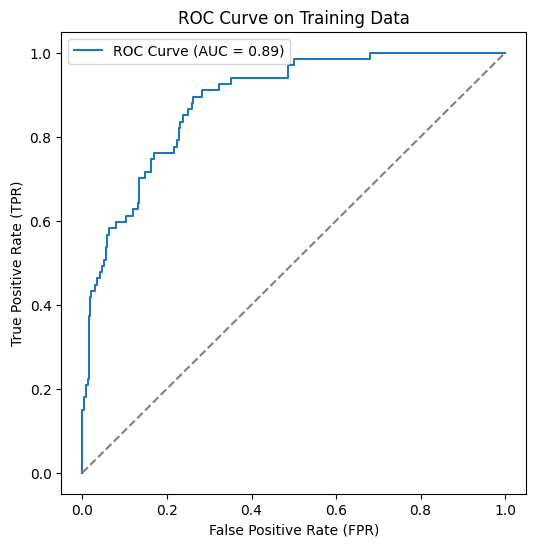

In [23]:
# Training Data Evaluation Metrics

# Predictions (discrete)
y_train_pred = best_model.predict(X_train)

print("Training Data Evaluation Metrics:")

# Confusion matrix
cm_train = confusion_matrix(y_train, y_train_pred)
tn, fp, fn, tp = cm_train.ravel()
print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")
print(f"False Negatives (FN): {fn}")

# Precision & Recall
precision = precision_score(y_train, y_train_pred)
recall = recall_score(y_train, y_train_pred)
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")

# Continuous scores for AUROC
if hasattr(best_model, "predict_proba"):
    y_scores = best_model.predict_proba(X_train)[:, 1]
elif hasattr(best_model, "decision_function"):
    y_scores = best_model.decision_function(X_train)
else:
    y_scores = y_train_pred  # fallback (not ideal)

# AUROC
roc_auc = roc_auc_score(y_train, y_scores)
print(f"AUC-ROC Score: {roc_auc:.4f}")

# ROC curve
fpr, tpr, _ = roc_curve(y_train, y_scores)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, linestyle='-', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random classifier line
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve on Training Data")
plt.legend()
plt.show()

Testing Data Evaluation Metrics:
True Positives (TP): 7
False Positives (FP): 23
True Negatives (TN): 59
False Negatives (FN): 10
Precision: 0.233
Recall: 0.412
AUC-ROC Score: 0.6729


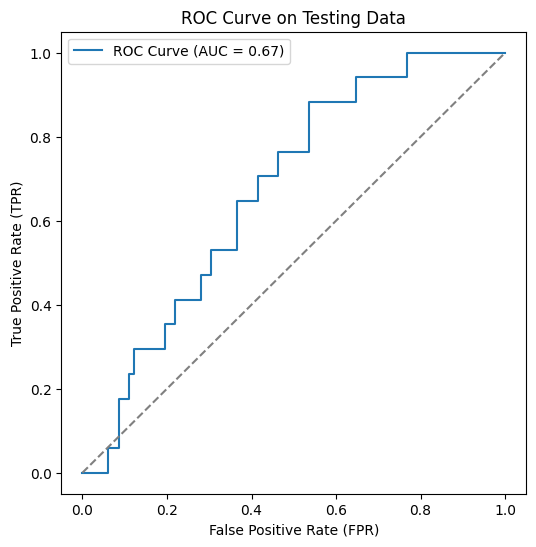

In [24]:
# Training Data Evaluation Metrics

# Predictions (discrete)
y_test_pred = best_model.predict(X_test)

print("Testing Data Evaluation Metrics:")

# Confusion matrix
cm_test = confusion_matrix(y_test, y_test_pred)
tn, fp, fn, tp = cm_test.ravel()
print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")
print(f"False Negatives (FN): {fn}")

# Precision & Recall
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")

# Continuous scores for AUROC
if hasattr(best_model, "predict_proba"):
    y_scores = best_model.predict_proba(X_test)[:, 1]
elif hasattr(best_model, "decision_function"):
    y_scores = best_model.decision_function(X_test)
else:
    y_scores = y_test_pred  # fallback (not ideal)

# AUROC
roc_auc = roc_auc_score(y_test, y_scores)
print(f"AUC-ROC Score: {roc_auc:.4f}")

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_scores)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, linestyle='-', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random classifier line
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve on Testing Data")
plt.legend()
plt.show()